In [1]:
"""
NEURAL NETWORKS AND DEEP LEARNING

ICT FOR LIFE AND HEALTH - Department of Information Engineering
PHYSICS OF DATA - Department of Physics and Astronomy
COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY - Department of Psychology

A.A. 2019/20 (6 CFU)
Dr. Alberto Testolin, Dr. Federico Chiariotti

Author: Dr. Matteo Gadaleta

Lab. 04 - Autoencoders


Modified by: Tommaso Tabarelli

"""

import os
import torch
import matplotlib.pyplot as plt
import random
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import numpy as np
from tqdm import tqdm

from datetime import datetime


#%% Define paths

#data_root_dir = '../datasets'
data_root_dir = 'datasets'


#%% Create dataset

train_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

train_dataset = MNIST(data_root_dir, train=True,  download=False, transform=train_transform)
test_dataset  = MNIST(data_root_dir, train=False, download=False, transform=test_transform)

### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

### Define the network architecture

In [2]:
#%% Define the network architecture
    
class Autoencoder(nn.Module):
    
    def __init__(self, hidden_units, encoded_space_dim):
        super().__init__()

        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
            )
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, hidden_units),
            nn.ReLU(True),
            nn.Linear(hidden_units, encoded_space_dim)
            )
        
        ### Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, hidden_units),
            nn.ReLU(True),
            nn.Linear(hidden_units, 3 * 3 * 32),
            nn.ReLU(True)
            )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
            )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 3, 3])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

### Initialize the network

In [3]:
### Initialize the network
hidden_units = 100
encoded_space_dim = 6
net = Autoencoder(hidden_units=hidden_units, encoded_space_dim=encoded_space_dim)

### Some examples
# Take an input image (remember to add the batch dimension)
img = test_dataset[0][0].unsqueeze(0)
print('Original image shape:', img.shape)
# Encode the image
img_enc = net.encode(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = net.decode(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 8])
Decoded image shape: torch.Size([1, 1, 28, 28])


### Prepare training

In [4]:
#%% Prepare training

batch_size = 500

# Fraction for validation (assuming data are already shuffled)
vf = 0.2
tot = len(train_dataset)

# Manually building the validation and train dataset (slicing are not allowed)
valid_dataset = [train_dataset[ii] for ii in range(int(vf*tot))]
train_dataset = [train_dataset[ii] for ii in range(int(vf*tot), tot)]

### Define dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True )
test_dataloader  = DataLoader(test_dataset , batch_size=batch_size, shuffle=False)

### Define a loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer
lr = 1e-3 # Learning rate
optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

### If cuda is available set the device to GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# Move all the network parameters to the selected device (if they are already on that device nothing happens)
net.to(device)

Autoencoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=50, out_features=8, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=50, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvT

### Network training

In [5]:
#%% Network training

### Training function
def train_epoch(net, dataloader, loss_fn, optimizer):
    # Abilitating training mode
    net.train()
    for sample_batch in dataloader:
        # Extract data and move tensors to the selected device
        # Batches are lists of 2 elements:
        #  - the first one is a sample of images, 512, which are 28x28 matrices
        #  - the second one is a list of labels, corresponding to the images
        image_batch = sample_batch[0].to(device)
        # Forward pass
        output = net(image_batch)
        loss = loss_fn(output, image_batch)
        
        # --- Backward pass ---
        # Setting gradient to 0 (avoiding mistakes due to previous steps)
        optim.zero_grad()
        # Backpropagating
        loss.backward()
        # Updating
        optim.step()
        
        # Print loss
        #print('\t partial train loss: %f' % (loss.data))


### Testing function
def test_epoch(net, dataloader, loss_fn, optimizer):
    # Validation
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # No need to track the gradients
        conc_out = torch.Tensor().float()
        conc_label = torch.Tensor().float()
        for sample_batch in dataloader:
            # Extract data and move tensors to the selected device
            image_batch = sample_batch[0].to(device)
            # Forward pass
            out = net(image_batch)
            # Concatenate with previous outputs
            conc_out = torch.cat([conc_out, out.cpu()])
            conc_label = torch.cat([conc_label, image_batch.cpu()]) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## Simple training procedure (skip to grid-search)

In [8]:
### Training cycle
num_epochs = 400

num_trained_epochs = num_epochs


### Initialize the network
hidden_units = 100
encoded_space_dim = 6
net = Autoencoder(hidden_units=hidden_units, encoded_space_dim=encoded_space_dim)
net.to(device)

### Define an optimizer
lr = 1e-3 # Learning rate
optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

train_losses = []
valid_losses = []

# Saving current time
time_start = datetime.now()

# Creating directories
path = str("%4d-%2.2d-%2.2d_%2.2d:%2.2d" % (time_start.year,
                                            time_start.month, 
                                            time_start.day,
                                            time_start.hour,
                                            time_start.minute)
          )
path_param = path + ''
path_img = path_param + '/autoencoder_progress_%d_features' % (encoded_space_dim) 
os.makedirs(path_img, exist_ok=True)


# Patience for early stopping
patience = 10

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    
    # --- Training ---
    # Training on all batches in the dataloader
    train_epoch(net, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optim)
    
    # --- Validation ---
    val_loss = test_epoch(net, dataloader=valid_dataloader, loss_fn=loss_fn, optimizer=optim)
    # Saving validation loss
    valid_losses.append(val_loss)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    img = valid_dataset[1][0].unsqueeze(0).to(device)
    
    net.eval()
    
    with torch.no_grad():
        rec_img = net(img)
    
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image: %d' % (int(valid_dataset[1][1])) )
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    #plt.pause(0.1)
    
    # Save figures
    #os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    plt.savefig(str(path_img+'/epoch_%d.png' % (epoch + 1)) )
    #plt.show()
    plt.close()
    
    # Implementing a simple early stopping
    #  (comparing the last loss with the average of the previous 'patience' ones)
    if (len(valid_losses) > (patience+1)):
        compare_loss = 0
        for loss_ in valid_losses[-(patience+1):-1]:
            compare_loss += loss_
        if valid_losses[-1] > (compare_loss/patience):
            print("----------")
            print("---------- Ending due to increasing value of validation loss (overfitting) ----------")
            print("----------")
            
            print("\"Invaid\" loss: %.7f (vs. avg of previous %d losses: %.7f)" % (valid_losses[-1],
                                                                                   patience,
                                                                                   compare_loss/patience)
                 )
            num_trained_epochs = epoch+1
            break
    
    # Save network parameters (only if validation loss is valid)
    torch.save(net.state_dict(), str(path+'/net_params.pth'))

time_end = datetime.now()

EPOCH 1/400


	 VALIDATION - EPOCH 1/400 - loss: 0.073322


EPOCH 2/400


	 VALIDATION - EPOCH 2/400 - loss: 0.067179


EPOCH 3/400


KeyboardInterrupt: 

## Grid search procedure (implemented manually)

In [14]:
### Training cycle
num_epochs = 400

### Define a loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer
lr = 1e-3 # Learning rate
optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

# Getting current data and time
now = datetime.now()

# Creating directories
path = str("%4d-%2.2d-%2.2d_%2.2d:%2.2d" % (now.year,
                                            now.month, 
                                            now.day,
                                            now.hour,
                                            now.minute)
          )

patience = 10

hidden_units_list = [50, 100, 500]
encoded_space_dim_list = [2, 4, 6, 8]
lr_list = [1e-1, 1e-2, 1e-3]

for hu in hidden_units_list:
    for esd in encoded_space_dim_list:
        for lr in lr_list:

            print("---------- PARAMETERS ----------")
            print("Hidden units:", hu)
            print("Encoded space dimension:", esd)
            print("Patience:", patience)
            print("Learning rate:", lr, end="\n\n")

            # Initializing network

            net = Autoencoder(hidden_units=hu, encoded_space_dim=esd)
            net.to(device)
            optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

            num_trained_epochs = num_epochs

            train_losses = []
            valid_losses = []

            # Saving current time
            time_start = datetime.now()

            path_param = path + str('/hu%3.3d_esd%2.2d_lr%6.5f' % (hu, esd, lr))
            path_img = path_param + '/Progress'
            os.makedirs(path_img, exist_ok=True)

            # Patience for early stopping
            patience = 10

            for epoch in range(num_epochs):
                print('EPOCH %d/%d' % (epoch + 1, num_epochs))

                # --- Training ---
                # Training on all batches in the dataloader
                train_epoch(net, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optim)

                # --- Validation ---
                val_loss = test_epoch(net, dataloader=valid_dataloader, loss_fn=loss_fn, optimizer=optim)
                # Saving validation loss
                valid_losses.append(val_loss)
                # Print Validationloss
                print('\n\t VALIDATION - EPOCH %d/%d - loss: %15.14f\n' % (epoch + 1, num_epochs, val_loss))

                ### Plot progress
                img = valid_dataset[1][0].unsqueeze(0).to(device)

                net.eval()

                with torch.no_grad():
                    rec_img = net(img)

                fig, axs = plt.subplots(1, 2, figsize=(12,6))
                axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
                axs[0].set_title('Original image: %d' % (int(valid_dataset[1][1])) )
                axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
                axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
                plt.tight_layout()
                #plt.pause(0.1)

                # Save figures
                #os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
                plt.savefig(str(path_img+'/epoch_%d.png' % (epoch + 1)) )
                #plt.show()
                plt.close()

                # Implementing early stopping
                #  (comparing the last loss with the average of the previous 'patience' ones)
                if (len(valid_losses) >= (patience+1)):
                    compare_loss = 0
                    for loss_ in valid_losses[-(patience+1):-1]:
                        compare_loss += loss_
                    if valid_losses[-1] >= (compare_loss/patience):
                        print("----------")
                        print("---------- Ending due to increasing value of validation loss (overfitting) ----------")
                        print("----------")

                        print("\"Invaid\" loss: %.7f (vs. avg of previous %d losses: %.7f)" % (valid_losses[-1],
                                                                                               patience,
                                                                                               compare_loss/patience)
                             )
                        # Saving the number of actual epochs done
                        num_trained_epochs = epoch+1
                        break

                # Save network parameters (only if validation loss is valid)
                torch.save(net.state_dict(), str(path_param+'/net_params.pth'))

            time_end = datetime.now()

            # Printing useful informations
            print("Number of trained epochs: %d/%d" % (num_trained_epochs, num_epochs) )
            print("Hidden units:", hu)
            print("Encoded space dimension:", esd)
            print("Patience:", patience)
            print("Learning rate:", lr)
            time_seconds = (time_end - time_start).total_seconds()
            print("The train process took:", time_seconds, "seconds,")
            print("\twhich are about %.2f" % (time_seconds/60), "minutes.")
            # Printing the one but last validation loss since the parameters were
            #  not updated using the last validation, since it is supposed "invalid"
            #  due to early stopping procedure (the number of epochs was chosen big so that
            #  the procedure is more likely to finish due to early stopping test)
            print("(Last) Validation loss: %.7f" % (valid_losses[-2]))
            net.eval()
            test_loss = test_epoch(net, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim)
            print("Test loss: %.7f\n\n" % (test_loss))


            # Printing stuff to file
            ofile = open( str(path_param+"/Params"), mode="w")

            ofile.write(str("Trained_epochs: %d/%d" % (num_trained_epochs, num_epochs)+"\n\r") )
            ofile.write(str("Hidden_units: "+str(hu)+"\n\r") )
            ofile.write(str("Encoded_space_dimension: "+str(esd)+"\n\r") )
            ofile.write(str("Patience: %d\n\r") % (patience) )
            ofile.write(str("Learning_rate: %f\n\r") % (lr) )
            ofile.write(str("Time_spend: "+str(time_seconds)+"\n\r") )
            
            ofile.write(str("Validation_loss: %.7f\n\r" % (valid_losses[-2]) ) )
            ofile.write(str("Test_loss: %.7f\n\r" % (test_loss) ) )

            ofile.close()

            ### Plotting and saving validation loss
            plt.figure(figsize = (12,10))
            plt.title("Validation loss", fontsize = 25)
            plt.ylabel("Loss", fontsize = 15)
            plt.xlabel("Epoch", fontsize = 15)
            plt.plot(valid_losses)
            plt.savefig(str(path_param+'/Valid_loss_plot.png'))
            #plt.show()
            plt.close()

---------- PARAMETERS ----------
Hidden units: 50
Encoded space dimension: 2
Patience: 10
Learning rate: 0.1

EPOCH 1/400

	 VALIDATION - EPOCH 1/400 - loss: 0.06853157281876

EPOCH 2/400

	 VALIDATION - EPOCH 2/400 - loss: 0.06776028871536

EPOCH 3/400

	 VALIDATION - EPOCH 3/400 - loss: 0.06770291924477

EPOCH 4/400

	 VALIDATION - EPOCH 4/400 - loss: 0.06765251606703

EPOCH 5/400

	 VALIDATION - EPOCH 5/400 - loss: 0.06773115694523

EPOCH 6/400

	 VALIDATION - EPOCH 6/400 - loss: 0.06768789887428

EPOCH 7/400

	 VALIDATION - EPOCH 7/400 - loss: 0.06785508990288

EPOCH 8/400

	 VALIDATION - EPOCH 8/400 - loss: 0.06772243231535

EPOCH 9/400

	 VALIDATION - EPOCH 9/400 - loss: 0.06769476085901

EPOCH 10/400

	 VALIDATION - EPOCH 10/400 - loss: 0.06765576452017

EPOCH 11/400

	 VALIDATION - EPOCH 11/400 - loss: 0.06768103688955

EPOCH 12/400

	 VALIDATION - EPOCH 12/400 - loss: 0.06761532276869

EPOCH 13/400

	 VALIDATION - EPOCH 13/400 - loss: 0.06767490506172

EPOCH 14/400

	 VALIDATI


	 VALIDATION - EPOCH 55/400 - loss: 0.04049655050039

EPOCH 56/400

	 VALIDATION - EPOCH 56/400 - loss: 0.04033235833049

EPOCH 57/400

	 VALIDATION - EPOCH 57/400 - loss: 0.04026674106717

EPOCH 58/400

	 VALIDATION - EPOCH 58/400 - loss: 0.04029798880219

EPOCH 59/400

	 VALIDATION - EPOCH 59/400 - loss: 0.04019500687718

EPOCH 60/400

	 VALIDATION - EPOCH 60/400 - loss: 0.04015232995152

EPOCH 61/400

	 VALIDATION - EPOCH 61/400 - loss: 0.04022569581866

EPOCH 62/400

	 VALIDATION - EPOCH 62/400 - loss: 0.04014786332846

EPOCH 63/400

	 VALIDATION - EPOCH 63/400 - loss: 0.04011901840568

EPOCH 64/400

	 VALIDATION - EPOCH 64/400 - loss: 0.04002156853676

EPOCH 65/400

	 VALIDATION - EPOCH 65/400 - loss: 0.04019115492702

EPOCH 66/400

	 VALIDATION - EPOCH 66/400 - loss: 0.04004935547709

EPOCH 67/400

	 VALIDATION - EPOCH 67/400 - loss: 0.03990879282355

EPOCH 68/400

	 VALIDATION - EPOCH 68/400 - loss: 0.03982977941632

EPOCH 69/400

	 VALIDATION - EPOCH 69/400 - loss: 0.039963588


	 VALIDATION - EPOCH 6/400 - loss: 0.05005040392280

EPOCH 7/400

	 VALIDATION - EPOCH 7/400 - loss: 0.04578728228807

EPOCH 8/400

	 VALIDATION - EPOCH 8/400 - loss: 0.04268657788634

EPOCH 9/400

	 VALIDATION - EPOCH 9/400 - loss: 0.04059994593263

EPOCH 10/400

	 VALIDATION - EPOCH 10/400 - loss: 0.03896744176745

EPOCH 11/400

	 VALIDATION - EPOCH 11/400 - loss: 0.03794395923615

EPOCH 12/400

	 VALIDATION - EPOCH 12/400 - loss: 0.03677447512746

EPOCH 13/400

	 VALIDATION - EPOCH 13/400 - loss: 0.03584845736623

EPOCH 14/400

	 VALIDATION - EPOCH 14/400 - loss: 0.03486255928874

EPOCH 15/400

	 VALIDATION - EPOCH 15/400 - loss: 0.03410932049155

EPOCH 16/400

	 VALIDATION - EPOCH 16/400 - loss: 0.03347272425890

EPOCH 17/400

	 VALIDATION - EPOCH 17/400 - loss: 0.03301816806197

EPOCH 18/400

	 VALIDATION - EPOCH 18/400 - loss: 0.03276701271534

EPOCH 19/400

	 VALIDATION - EPOCH 19/400 - loss: 0.03237565979362

EPOCH 20/400

	 VALIDATION - EPOCH 20/400 - loss: 0.03216157853603




	 VALIDATION - EPOCH 23/400 - loss: 0.06765940040350

EPOCH 24/400

	 VALIDATION - EPOCH 24/400 - loss: 0.06760517507792

EPOCH 25/400

	 VALIDATION - EPOCH 25/400 - loss: 0.06762750446796

EPOCH 26/400

	 VALIDATION - EPOCH 26/400 - loss: 0.06756207346916

EPOCH 27/400

	 VALIDATION - EPOCH 27/400 - loss: 0.06761722266674

EPOCH 28/400

	 VALIDATION - EPOCH 28/400 - loss: 0.06755211204290

EPOCH 29/400

	 VALIDATION - EPOCH 29/400 - loss: 0.06757015734911

EPOCH 30/400

	 VALIDATION - EPOCH 30/400 - loss: 0.06763362139463

----------
---------- Ending due to increasing value of validation loss (overfitting) ----------
----------
"Invaid" loss: 0.0676336 (vs. avg of previous 10 losses: 0.0676220)
Number of trained epochs: 30/400
Hidden units: 50
Encoded space dimension: 6
Patience: 10
Learning rate: 0.01
The train process took: 429.267438 seconds,
	which are about 7.15 minutes.
(Last) Validation loss: 0.0676336
Test loss: 0.0676612


---------- PARAMETERS ----------
Hidden units: 50
E

Test loss: 0.0217832


---------- PARAMETERS ----------
Hidden units: 50
Encoded space dimension: 8
Patience: 10
Learning rate: 0.1

EPOCH 1/400

	 VALIDATION - EPOCH 1/400 - loss: 0.10978141427040

EPOCH 2/400

	 VALIDATION - EPOCH 2/400 - loss: 0.11109019070864

EPOCH 3/400

	 VALIDATION - EPOCH 3/400 - loss: 0.11086809635162

EPOCH 4/400

	 VALIDATION - EPOCH 4/400 - loss: 0.10759880393744

EPOCH 5/400

	 VALIDATION - EPOCH 5/400 - loss: 0.11775730550289

EPOCH 6/400

	 VALIDATION - EPOCH 6/400 - loss: 0.11241098493338

EPOCH 7/400

	 VALIDATION - EPOCH 7/400 - loss: 0.11212421953678

EPOCH 8/400

	 VALIDATION - EPOCH 8/400 - loss: 0.11211524903774

EPOCH 9/400

	 VALIDATION - EPOCH 9/400 - loss: 0.12269961833954

EPOCH 10/400

	 VALIDATION - EPOCH 10/400 - loss: 0.11322047561407

EPOCH 11/400

	 VALIDATION - EPOCH 11/400 - loss: 0.11322046816349

----------
---------- Ending due to increasing value of validation loss (overfitting) ----------
----------
"Invaid" loss: 0.1132205 (vs.


	 VALIDATION - EPOCH 65/400 - loss: 0.01821603067219

EPOCH 66/400

	 VALIDATION - EPOCH 66/400 - loss: 0.01814504526556

EPOCH 67/400

	 VALIDATION - EPOCH 67/400 - loss: 0.01809682697058

EPOCH 68/400

	 VALIDATION - EPOCH 68/400 - loss: 0.01813146285713

EPOCH 69/400

	 VALIDATION - EPOCH 69/400 - loss: 0.01799757033587

EPOCH 70/400

	 VALIDATION - EPOCH 70/400 - loss: 0.01803042739630

EPOCH 71/400

	 VALIDATION - EPOCH 71/400 - loss: 0.01801984570920

EPOCH 72/400

	 VALIDATION - EPOCH 72/400 - loss: 0.01798404008150

EPOCH 73/400

	 VALIDATION - EPOCH 73/400 - loss: 0.01790067553520

EPOCH 74/400

	 VALIDATION - EPOCH 74/400 - loss: 0.01792060397565

EPOCH 75/400

	 VALIDATION - EPOCH 75/400 - loss: 0.01782193407416

EPOCH 76/400

	 VALIDATION - EPOCH 76/400 - loss: 0.01783960498869

EPOCH 77/400

	 VALIDATION - EPOCH 77/400 - loss: 0.01773599721491

EPOCH 78/400

	 VALIDATION - EPOCH 78/400 - loss: 0.01770028658211

EPOCH 79/400

	 VALIDATION - EPOCH 79/400 - loss: 0.017759120


	 VALIDATION - EPOCH 36/400 - loss: 0.04046884551644

EPOCH 37/400

	 VALIDATION - EPOCH 37/400 - loss: 0.04038573056459

EPOCH 38/400

	 VALIDATION - EPOCH 38/400 - loss: 0.04033890366554

EPOCH 39/400

	 VALIDATION - EPOCH 39/400 - loss: 0.04010356590152

EPOCH 40/400

	 VALIDATION - EPOCH 40/400 - loss: 0.04019664600492

EPOCH 41/400

	 VALIDATION - EPOCH 41/400 - loss: 0.04000566527247

EPOCH 42/400

	 VALIDATION - EPOCH 42/400 - loss: 0.04006483405828

EPOCH 43/400

	 VALIDATION - EPOCH 43/400 - loss: 0.03998074308038

EPOCH 44/400

	 VALIDATION - EPOCH 44/400 - loss: 0.03993925452232

EPOCH 45/400

	 VALIDATION - EPOCH 45/400 - loss: 0.03987222164869

EPOCH 46/400

	 VALIDATION - EPOCH 46/400 - loss: 0.03972437605262

EPOCH 47/400

	 VALIDATION - EPOCH 47/400 - loss: 0.03982013836503

EPOCH 48/400

	 VALIDATION - EPOCH 48/400 - loss: 0.03969876840711

EPOCH 49/400

	 VALIDATION - EPOCH 49/400 - loss: 0.03980503603816

EPOCH 50/400

	 VALIDATION - EPOCH 50/400 - loss: 0.039698258


	 VALIDATION - EPOCH 14/400 - loss: 0.03270881250501

EPOCH 15/400

	 VALIDATION - EPOCH 15/400 - loss: 0.03229349851608

EPOCH 16/400

	 VALIDATION - EPOCH 16/400 - loss: 0.03177557885647

EPOCH 17/400

	 VALIDATION - EPOCH 17/400 - loss: 0.03156099468470

EPOCH 18/400

	 VALIDATION - EPOCH 18/400 - loss: 0.03125415369868

EPOCH 19/400

	 VALIDATION - EPOCH 19/400 - loss: 0.03104146569967

EPOCH 20/400

	 VALIDATION - EPOCH 20/400 - loss: 0.03090280108154

EPOCH 21/400

	 VALIDATION - EPOCH 21/400 - loss: 0.03065195865929

EPOCH 22/400

	 VALIDATION - EPOCH 22/400 - loss: 0.03044584207237

EPOCH 23/400

	 VALIDATION - EPOCH 23/400 - loss: 0.03030735440552

EPOCH 24/400

	 VALIDATION - EPOCH 24/400 - loss: 0.03003912605345

EPOCH 25/400

	 VALIDATION - EPOCH 25/400 - loss: 0.02997354604304

EPOCH 26/400

	 VALIDATION - EPOCH 26/400 - loss: 0.02995249629021

EPOCH 27/400

	 VALIDATION - EPOCH 27/400 - loss: 0.02957594953477

EPOCH 28/400

	 VALIDATION - EPOCH 28/400 - loss: 0.029579255

Test loss: 0.0216872


---------- PARAMETERS ----------
Hidden units: 100
Encoded space dimension: 6
Patience: 10
Learning rate: 0.001

EPOCH 1/400

	 VALIDATION - EPOCH 1/400 - loss: 0.09756097942591

EPOCH 2/400

	 VALIDATION - EPOCH 2/400 - loss: 0.06378174573183

EPOCH 3/400

	 VALIDATION - EPOCH 3/400 - loss: 0.06087436527014

EPOCH 4/400

	 VALIDATION - EPOCH 4/400 - loss: 0.05565635487437

EPOCH 5/400

	 VALIDATION - EPOCH 5/400 - loss: 0.04908622801304

EPOCH 6/400

	 VALIDATION - EPOCH 6/400 - loss: 0.04577869549394

EPOCH 7/400

	 VALIDATION - EPOCH 7/400 - loss: 0.04037945345044

EPOCH 8/400

	 VALIDATION - EPOCH 8/400 - loss: 0.03612540289760

EPOCH 9/400

	 VALIDATION - EPOCH 9/400 - loss: 0.03393325954676

EPOCH 10/400

	 VALIDATION - EPOCH 10/400 - loss: 0.03231558576226

EPOCH 11/400

	 VALIDATION - EPOCH 11/400 - loss: 0.03094833716750

EPOCH 12/400

	 VALIDATION - EPOCH 12/400 - loss: 0.02999120019376

EPOCH 13/400

	 VALIDATION - EPOCH 13/400 - loss: 0.02909325994551


	 VALIDATION - EPOCH 25/400 - loss: 0.01784355193377

EPOCH 26/400

	 VALIDATION - EPOCH 26/400 - loss: 0.01776771061122

EPOCH 27/400

	 VALIDATION - EPOCH 27/400 - loss: 0.01930681988597

----------
---------- Ending due to increasing value of validation loss (overfitting) ----------
----------
"Invaid" loss: 0.0193068 (vs. avg of previous 10 losses: 0.0182442)
Number of trained epochs: 27/400
Hidden units: 100
Encoded space dimension: 8
Patience: 10
Learning rate: 0.01
The train process took: 288.861449 seconds,
	which are about 4.81 minutes.
(Last) Validation loss: 0.0193068
Test loss: 0.0193645


---------- PARAMETERS ----------
Hidden units: 100
Encoded space dimension: 8
Patience: 10
Learning rate: 0.001

EPOCH 1/400

	 VALIDATION - EPOCH 1/400 - loss: 0.10823587328196

EPOCH 2/400

	 VALIDATION - EPOCH 2/400 - loss: 0.06498382240534

EPOCH 3/400

	 VALIDATION - EPOCH 3/400 - loss: 0.06120122596622

EPOCH 4/400

	 VALIDATION - EPOCH 4/400 - loss: 0.05661670491099

EPOCH 5/400



Test loss: 0.1178705


---------- PARAMETERS ----------
Hidden units: 500
Encoded space dimension: 2
Patience: 10
Learning rate: 0.01

EPOCH 1/400

	 VALIDATION - EPOCH 1/400 - loss: 0.06151174381375

EPOCH 2/400

	 VALIDATION - EPOCH 2/400 - loss: 0.05205293372273

EPOCH 3/400

	 VALIDATION - EPOCH 3/400 - loss: 0.04874010384083

EPOCH 4/400

	 VALIDATION - EPOCH 4/400 - loss: 0.04658041894436

EPOCH 5/400

	 VALIDATION - EPOCH 5/400 - loss: 0.04512371122837

EPOCH 6/400

	 VALIDATION - EPOCH 6/400 - loss: 0.04457183927298

EPOCH 7/400

	 VALIDATION - EPOCH 7/400 - loss: 0.04374596849084

EPOCH 8/400

	 VALIDATION - EPOCH 8/400 - loss: 0.04344319179654

EPOCH 9/400

	 VALIDATION - EPOCH 9/400 - loss: 0.04298726469278

EPOCH 10/400

	 VALIDATION - EPOCH 10/400 - loss: 0.04277007281780

EPOCH 11/400

	 VALIDATION - EPOCH 11/400 - loss: 0.04232411086559

EPOCH 12/400

	 VALIDATION - EPOCH 12/400 - loss: 0.04257606342435

EPOCH 13/400

	 VALIDATION - EPOCH 13/400 - loss: 0.04194137454033



	 VALIDATION - EPOCH 70/400 - loss: 0.03712055459619

EPOCH 71/400

	 VALIDATION - EPOCH 71/400 - loss: 0.03704955428839

EPOCH 72/400

	 VALIDATION - EPOCH 72/400 - loss: 0.03712289407849

EPOCH 73/400

	 VALIDATION - EPOCH 73/400 - loss: 0.03707266971469

EPOCH 74/400

	 VALIDATION - EPOCH 74/400 - loss: 0.03715777397156

EPOCH 75/400

	 VALIDATION - EPOCH 75/400 - loss: 0.03725615888834

----------
---------- Ending due to increasing value of validation loss (overfitting) ----------
----------
"Invaid" loss: 0.0372562 (vs. avg of previous 10 losses: 0.0372408)
Number of trained epochs: 75/400
Hidden units: 500
Encoded space dimension: 2
Patience: 10
Learning rate: 0.001
The train process took: 1173.639307 seconds,
	which are about 19.56 minutes.
(Last) Validation loss: 0.0372562
Test loss: 0.0374737


---------- PARAMETERS ----------
Hidden units: 500
Encoded space dimension: 4
Patience: 10
Learning rate: 0.1

EPOCH 1/400

	 VALIDATION - EPOCH 1/400 - loss: 0.10704799741507

EPOCH 


	 VALIDATION - EPOCH 38/400 - loss: 0.02792117372155

EPOCH 39/400

	 VALIDATION - EPOCH 39/400 - loss: 0.02783060260117

EPOCH 40/400

	 VALIDATION - EPOCH 40/400 - loss: 0.02780484408140

EPOCH 41/400

	 VALIDATION - EPOCH 41/400 - loss: 0.02767057716846

EPOCH 42/400

	 VALIDATION - EPOCH 42/400 - loss: 0.02765603922307

EPOCH 43/400

	 VALIDATION - EPOCH 43/400 - loss: 0.02765779197216

EPOCH 44/400

	 VALIDATION - EPOCH 44/400 - loss: 0.02769572660327

EPOCH 45/400

	 VALIDATION - EPOCH 45/400 - loss: 0.02754334732890

EPOCH 46/400

	 VALIDATION - EPOCH 46/400 - loss: 0.02759497053921

EPOCH 47/400

	 VALIDATION - EPOCH 47/400 - loss: 0.02742074616253

EPOCH 48/400

	 VALIDATION - EPOCH 48/400 - loss: 0.02742611058056

EPOCH 49/400

	 VALIDATION - EPOCH 49/400 - loss: 0.02733943052590

EPOCH 50/400

	 VALIDATION - EPOCH 50/400 - loss: 0.02730096131563

EPOCH 51/400

	 VALIDATION - EPOCH 51/400 - loss: 0.02734848670661

EPOCH 52/400

	 VALIDATION - EPOCH 52/400 - loss: 0.027396762


	 VALIDATION - EPOCH 23/400 - loss: 0.02317292056978

EPOCH 24/400

	 VALIDATION - EPOCH 24/400 - loss: 0.02286249771714

EPOCH 25/400

	 VALIDATION - EPOCH 25/400 - loss: 0.02287790551782

EPOCH 26/400

	 VALIDATION - EPOCH 26/400 - loss: 0.02275192923844

EPOCH 27/400

	 VALIDATION - EPOCH 27/400 - loss: 0.02251263707876

EPOCH 28/400

	 VALIDATION - EPOCH 28/400 - loss: 0.02230415865779

EPOCH 29/400

	 VALIDATION - EPOCH 29/400 - loss: 0.02223439328372

EPOCH 30/400

	 VALIDATION - EPOCH 30/400 - loss: 0.02222551591694

EPOCH 31/400

	 VALIDATION - EPOCH 31/400 - loss: 0.02191443182528

EPOCH 32/400

	 VALIDATION - EPOCH 32/400 - loss: 0.02199887298048

EPOCH 33/400

	 VALIDATION - EPOCH 33/400 - loss: 0.02196166291833

EPOCH 34/400

	 VALIDATION - EPOCH 34/400 - loss: 0.02167194150388

EPOCH 35/400

	 VALIDATION - EPOCH 35/400 - loss: 0.02172813378274

EPOCH 36/400

	 VALIDATION - EPOCH 36/400 - loss: 0.02148431539536

EPOCH 37/400

	 VALIDATION - EPOCH 37/400 - loss: 0.021603846


	 VALIDATION - EPOCH 11/400 - loss: 0.02318450808525

EPOCH 12/400

	 VALIDATION - EPOCH 12/400 - loss: 0.02225353568792

EPOCH 13/400

	 VALIDATION - EPOCH 13/400 - loss: 0.02161177992821

EPOCH 14/400

	 VALIDATION - EPOCH 14/400 - loss: 0.02119889482856

EPOCH 15/400

	 VALIDATION - EPOCH 15/400 - loss: 0.02065627835691

EPOCH 16/400

	 VALIDATION - EPOCH 16/400 - loss: 0.02046425081789

EPOCH 17/400

	 VALIDATION - EPOCH 17/400 - loss: 0.02014565095305

EPOCH 18/400

	 VALIDATION - EPOCH 18/400 - loss: 0.01979641057551

EPOCH 19/400

	 VALIDATION - EPOCH 19/400 - loss: 0.01962853036821

EPOCH 20/400

	 VALIDATION - EPOCH 20/400 - loss: 0.01935736276209

EPOCH 21/400

	 VALIDATION - EPOCH 21/400 - loss: 0.01919857785106

EPOCH 22/400

	 VALIDATION - EPOCH 22/400 - loss: 0.01894716545939

EPOCH 23/400

	 VALIDATION - EPOCH 23/400 - loss: 0.01877581886947

EPOCH 24/400

	 VALIDATION - EPOCH 24/400 - loss: 0.01861653663218

EPOCH 25/400

	 VALIDATION - EPOCH 25/400 - loss: 0.018476270

## Retrieving all results (this cell should not be run again...)

In its output there are all the "training statistics" about time, epochs and so on...

In [42]:
# Path in which there are the main results
load_path = '2020-01-02_16:48'

best_val_loss = None
best_parameters_path = None

time_dictio = {}

total_time = 0
max_time = None
most_time_param = None

max_epochs = None
most_ep_param = None

for path_param in os.listdir(load_path):
    for line in open( str(load_path+"/"+path_param+"/Params") ):
        if "Validation_loss" in line:
            val_loss = float(line[-9:])
            #print("Path:", path_param, "\nValidation_loss:", val_loss, end='\n\n')
            if best_val_loss == None:
                best_val_loss = val_loss
            elif val_loss < best_val_loss:
                best_val_loss = val_loss
                best_parameters_path = path_param
        elif "Time_spend: " in line:
            time = float(line.replace("Time_spend: ", ""))
            if max_time == None:
                max_time = time
            elif time > max_time:
                max_time = time
                most_time_param = path_param

            time_dictio[path_param] = time
            total_time += time

        elif "Trained_epochs: " in line:
            actual_ep = line.replace("Trained_epochs: ", "")
            actual_ep = int(actual_ep.replace("/400", ""))
            if max_epochs == None:
                max_epochs = actual_ep
            elif actual_ep > max_epochs:
                max_epochs = actual_ep
                most_ep_param = path_param
            
print("Best val_loss:", best_val_loss)
print("Best parameters:", best_parameters_path)

#for par,time_ in zip(time_dictio.keys(), time_dictio.values()):
#    print("Params: ", par, "\nTime: ", time_, " seconds", end="\n\n")

print("\nTotal processing time: %.2f seconds" % total_time)
print("\twhich are about: %.2f minutes" % (total_time/60), end="\n\n")

print("Most time demanding parameters:", most_time_param, "\nTime spent:", max_time, 'seconds', end='')
print(" (~%.2f) minutes" % (max_time/60), end="\n\n" )

print("Most epoch demanding parameters:", most_ep_param, "\nEpoch spent:", max_epochs, end='\n\n')

Best val_loss: 0.0151675
Best parameters: hu500_esd08_lr0.00100

Total processing time: 46222.24 seconds
	which are about: 770.37 minutes

Most time demanding parameters: hu050_esd06_lr0.00100 
Time spent: 27109.685944 seconds (~451.83) minutes

Most epoch demanding parameters: hu050_esd06_lr0.00100 
Time spent: 100



## Re-training the best network using the whole training set (fixing the number of epochs)

In [44]:
# Retrieving best path (locally...)
best_path = load_path + "/" + best_parameters_path

# Retrieving correct parameters
for line in open( str(best_path+"/Params") ):
    if "Encoded_space_dimension: " in line:
        esd_ = int(line.replace("Encoded_space_dimension: ", ""))
    elif "Hidden_units: " in line:
        hu_ = int(line.replace("Hidden_units: ", ""))
    elif "Learning_rate: " in line:
        lr_ = float(line.replace('Learning_rate: ', ''))
    elif "Trained_epochs: " in line:
        num_ep = line.replace("Trained_epochs: ", "")
        num_ep = int(num_ep.replace("/400", ""))
    # No early stopping (only training)
    #elif "Patience: " in line:
    #    patience_ = int(line.replace("Patience: ", ""))

# Allowing a margin in the number of epochs due to the fact that now
#  the training set is bigger (is the whole training set, there are no more
#  train and validation sets)
num_epochs = num_ep + 10
        
### Initialize the network
net = Autoencoder(hidden_units=hu_, encoded_space_dim=esd_)
net.to(device)

### Define an optimizer
optim = torch.optim.Adam(net.parameters(), lr=lr_, weight_decay=1e-5)


# Saving current time
time_start = datetime.now()


# Creating directories
rt_path = str("Re_train_%4d-%2.2d-%2.2d_%2.2d:%2.2d" % (time_start.year,
                                            time_start.month, 
                                            time_start.day,
                                            time_start.hour,
                                            time_start.minute)
          )
path_param = rt_path + ''
path_img = path_param + '/Progress' 
os.makedirs(path_img, exist_ok=True)

# Loading again the train set
retrain_dataset = MNIST(data_root_dir, train=True,  download=False, transform=train_transform)
#batch_size = 500
retrain_dataloader = DataLoader(retrain_dataset, batch_size=batch_size, shuffle=True )

# Define a loss function
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    
    # --- Training ---
    # Training on all batches in the dataloader
    train_epoch(net, dataloader=retrain_dataloader, loss_fn=loss_fn, optimizer=optim)
    
    # --- Test ---
    test_loss = test_epoch(net, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim)
    
    # Print test loss
    print('\n\t Test - EPOCH %d/%d - loss: %f\n' % (epoch + 1, num_epochs, test_loss))

    ### Plot progress
    img = test_dataset[1][0].unsqueeze(0).to(device)
    
    net.eval()
    
    with torch.no_grad():
        rec_img = net(img)
    
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image: %d' % (int(valid_dataset[1][1])) )
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    
    # Save figures
    plt.savefig(str(path_img+'/epoch_%d.png' % (epoch + 1)) )
    plt.close()
    
    # Save network parameters
    torch.save(net.state_dict(), str(path_param+'/net_params.pth'))

time_end = datetime.now()

EPOCH 1/105

	 Test - EPOCH 1/105 - loss: 0.067949

EPOCH 2/105

	 Test - EPOCH 2/105 - loss: 0.061668

EPOCH 3/105

	 Test - EPOCH 3/105 - loss: 0.049100

EPOCH 4/105

	 Test - EPOCH 4/105 - loss: 0.038868

EPOCH 5/105

	 Test - EPOCH 5/105 - loss: 0.030816

EPOCH 6/105

	 Test - EPOCH 6/105 - loss: 0.027483

EPOCH 7/105

	 Test - EPOCH 7/105 - loss: 0.024428

EPOCH 8/105

	 Test - EPOCH 8/105 - loss: 0.023010

EPOCH 9/105

	 Test - EPOCH 9/105 - loss: 0.022175

EPOCH 10/105

	 Test - EPOCH 10/105 - loss: 0.021402

EPOCH 11/105

	 Test - EPOCH 11/105 - loss: 0.021161

EPOCH 12/105

	 Test - EPOCH 12/105 - loss: 0.020579

EPOCH 13/105

	 Test - EPOCH 13/105 - loss: 0.020247

EPOCH 14/105

	 Test - EPOCH 14/105 - loss: 0.019748

EPOCH 15/105

	 Test - EPOCH 15/105 - loss: 0.019360

EPOCH 16/105

	 Test - EPOCH 16/105 - loss: 0.019119

EPOCH 17/105

	 Test - EPOCH 17/105 - loss: 0.018944

EPOCH 18/105

	 Test - EPOCH 18/105 - loss: 0.018699

EPOCH 19/105

	 Test - EPOCH 19/105 - loss: 0.

In [46]:
# Printing useful informations
print("Number of trained epochs: %d" % (num_epochs) )
print("Hidden units:", hu_)
print("Encoded space dimension:", esd_)
print("Patience:", patience)
print("Learning rate:", lr_)
time_seconds = (time_end - time_start).total_seconds()
print("The train process took:", time_seconds, "seconds,")
print("\twhich are about %.2f" % (time_seconds/60), "minutes.")
# Printing the one but last validation loss since the parameters were
#  not updated using the last validation, since it is supposed "invalid"
#  due to early stopping procedure (the number of epochs was chosen big so that
#  the procedure is more likely to finish due to early stopping test)
test_loss = test_epoch(net, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim)
print("Test loss: %.7f\n\n" % (test_loss))


# Printing stuff to file
ofile = open( str(path_param+"/Params"), mode="w")

ofile.write(str("Trained_epochs: %d" % (num_epochs)+"\n\r") )
ofile.write(str("Hidden_units: "+str(hu_)+"\n\r") )
ofile.write(str("Encoded_space_dimension: "+str(esd_)+"\n\r") )
ofile.write(str("Patience: %d\n\r") % (patience) )
ofile.write(str("Learning_rate: %f\n\r") % (lr_) )
ofile.write(str("Time_spend: "+str(time_seconds)+"\n\r") )

ofile.write(str("Test_loss: %.7f\n\r" % (test_loss) ) )

ofile.close()

Number of trained epochs: 105
Hidden units: 500
Encoded space dimension: 8
Patience: 10
Learning rate: 0.001
The train process took: 2924.507174 seconds,
	which are about 48.74 minutes.
Test loss: 0.0143793




## Reconstructing some images

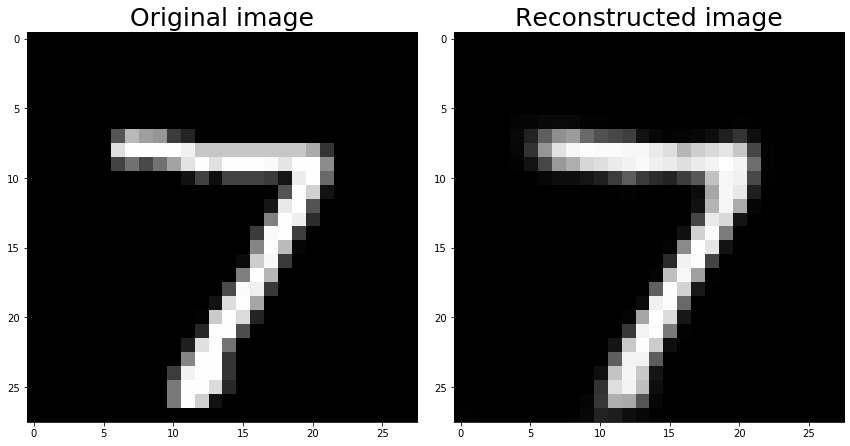

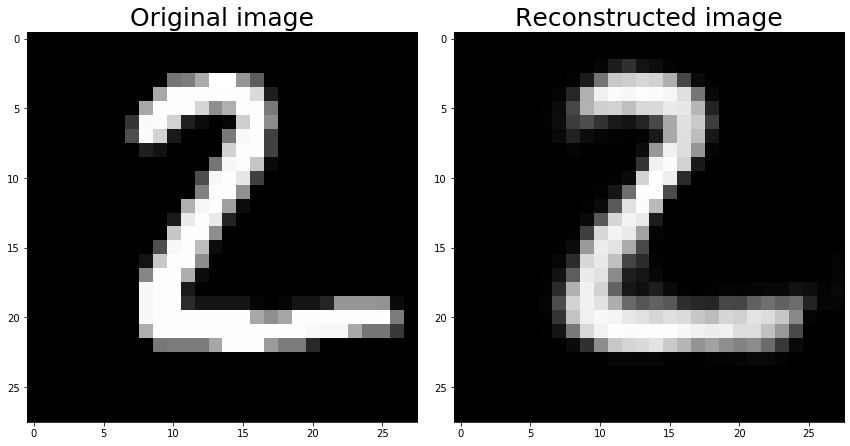

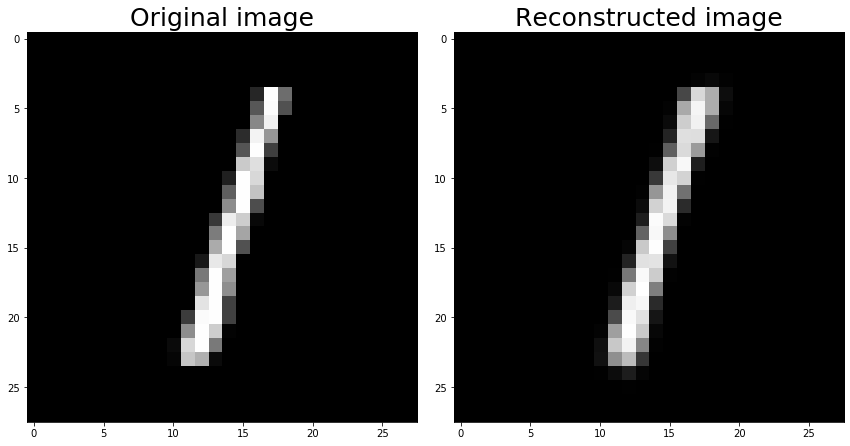

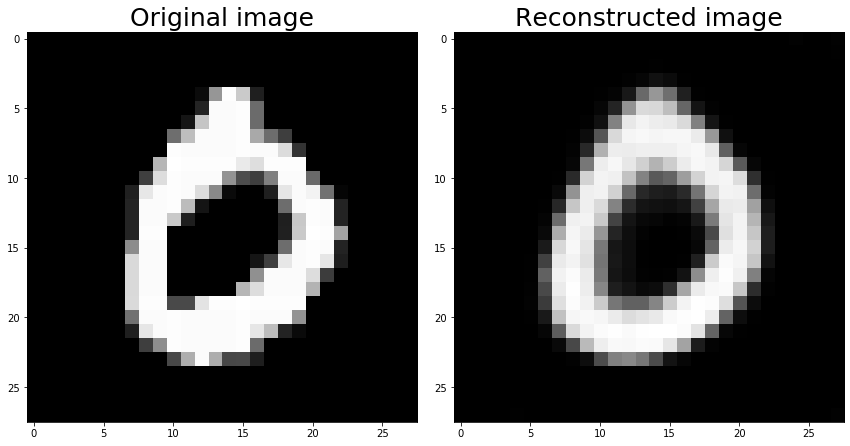

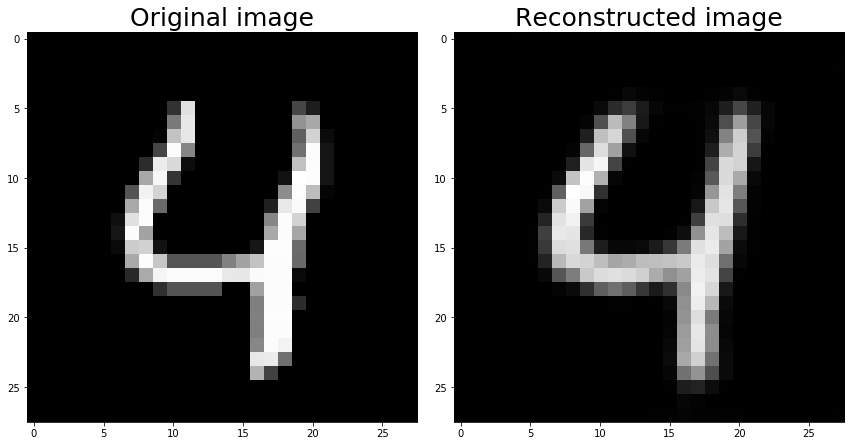

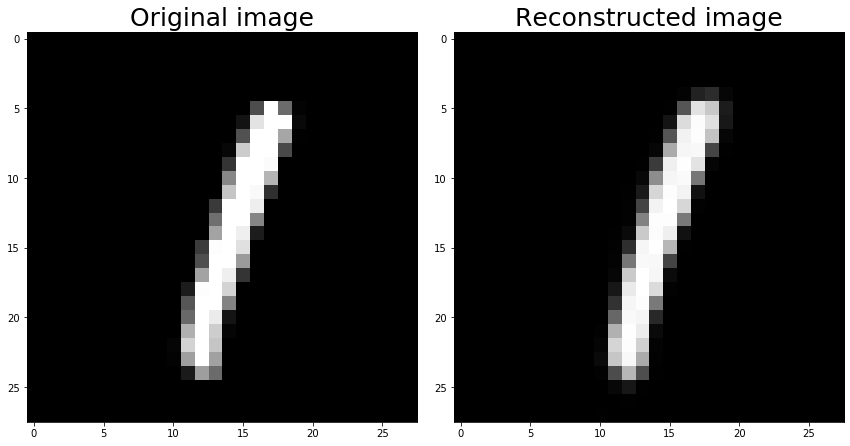

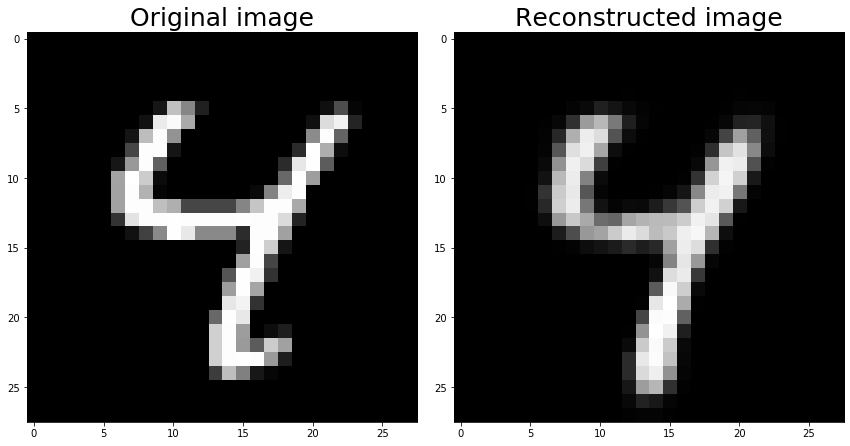

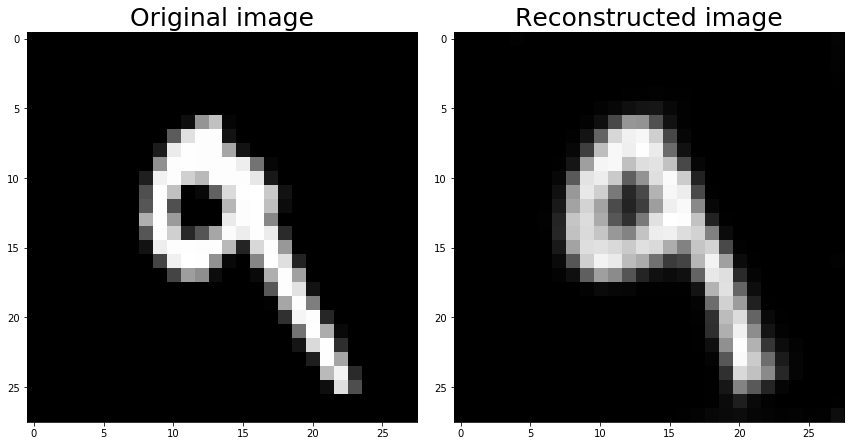

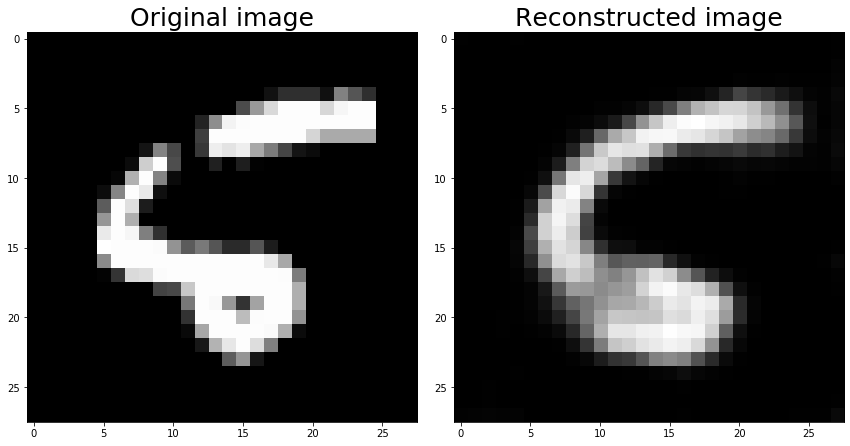

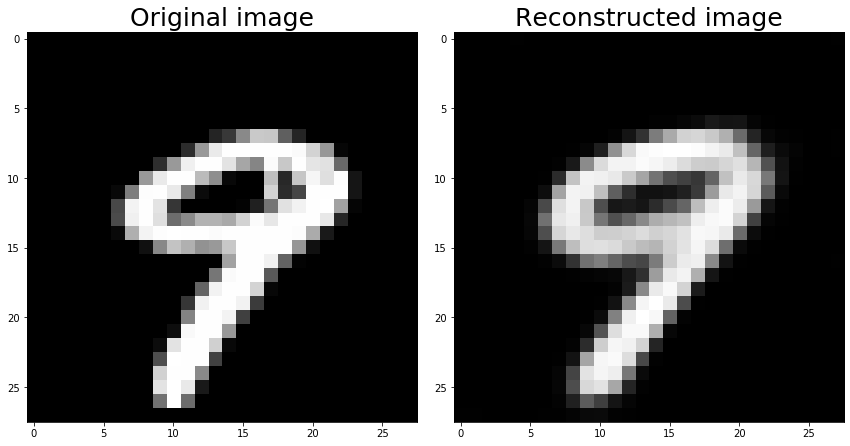

In [95]:
for cont in range(10):
    img = test_dataset[cont][0]
    img_reco = net(img.unsqueeze(0).to(device))

    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image', fontsize=25)
    axs[1].imshow(img_reco.cpu().squeeze().detach().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image', fontsize=25)

    plt.tight_layout()

    plt.savefig(str("Results/Reco/Img%2.2d.png" % (cont+1) ) )

## Trying to add noise to images

In [48]:
# Load network parameters
load_path = "Results"
net.load_state_dict(torch.load(str(load_path+'/net_params.pth'), map_location='cpu'))

<All keys matched successfully>

In [96]:
# Noise strenght

for noise_st in np.arange(0.05, 0.5, 0.05):
    noise_path = load_path + str("/Noise_%4.2f" % (noise_st))

    os.makedirs(noise_path, exist_ok=True)

    my_loss = 0
    my_cont = 0
    
    # Dealing only with first 10 images
    for cont in range(10):
        img = test_dataset[cont][0]
        img_corrupted = img + torch.empty((1,28,28)).normal_(mean=0,std=noise_st)
        # Cutting saturated values
        img_corrupted[img_corrupted<0] = 0
        img_corrupted[img_corrupted>1] = 1

        img_reco = net(img_corrupted.unsqueeze(0).to(device))

        fig, axs = plt.subplots(1, 3, figsize=(18,6))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image', fontsize=25)
        axs[1].imshow(img_corrupted.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Corrupted image', fontsize=25)
        axs[2].imshow(img_reco.cpu().squeeze().detach().numpy(), cmap='gist_gray')
        axs[2].set_title('Reconstructed image', fontsize=25)

        plt.tight_layout()

        plt.savefig(str(noise_path+"/Img%2.2d.png" % (cont+1) ) )
        
        my_loss += torch.sqrt(torch.sum((img-img_reco)**2))
        my_cont += 1
        # To avoid displaying figures... (see them in files, they are too many...)
        plt.close(fig)
    
    print("Parameters:\tnoise strenght: %2.2f" % (noise_st) )
    print("MSE per image:", my_loss.detach().numpy()/my_cont)
    print("MSE per pixel:", my_loss.detach().numpy()/my_cont/(28*28), "\n")

Parameters:	noise strenght: 0.05
MSE per image: 2.92603759765625
MSE per pixel: 0.0037321908133370533 

Parameters:	noise strenght: 0.10
MSE per image: 3.4334354400634766
MSE per pixel: 0.004379381938856475 

Parameters:	noise strenght: 0.15
MSE per image: 3.9741565704345705
MSE per pixel: 0.00506907725820736 

Parameters:	noise strenght: 0.20
MSE per image: 4.590590286254883
MSE per pixel: 0.005855344752876126 

Parameters:	noise strenght: 0.25
MSE per image: 4.989159393310547
MSE per pixel: 0.00636372371595733 

Parameters:	noise strenght: 0.30
MSE per image: 5.406654357910156
MSE per pixel: 0.006896242803456832 

Parameters:	noise strenght: 0.35
MSE per image: 5.7637886047363285
MSE per pixel: 0.007351771179510623 

Parameters:	noise strenght: 0.40
MSE per image: 6.168896102905274
MSE per pixel: 0.007868489927175095 

Parameters:	noise strenght: 0.45
MSE per image: 6.580554962158203
MSE per pixel: 0.00839356500275281 



## Trying with cut images

In [97]:
%matplotlib inline
cut_path = load_path + str("/cut")

os.makedirs(cut_path, exist_ok=True)

# Saving img square size
size_ = 28

# Setting coordinates to cut a window of the image (values from 0 to 1)
# Horizontal section
starth = 0.0
stoph = 0.7
# Vertical section
startv = 0.0
stopv = 1.0

for stoph in [0.5,0.7,1.0]:
    for stopv in [0.5,0.7,1.0]:
        
        my_loss = 0
        my_cont = 0
        
        # If the img is not cut, then do nothing
        if (stoph == 1.0 and stopv == 1.0):
            continue
        
        # Dealing only with first 10 images
        for cont in range(10):
            img = test_dataset[cont][0]
            img_cut = torch.zeros(img.shape)
            img_cut[:,int(startv*size_):int(stopv*size_),int(starth*size_):int(stoph*size_)] = img[:,int(startv*size_):int(stopv*size_),int(starth*size_):int(stoph*size_)]

            img_reco = net(img_cut.unsqueeze(0).to(device))

            fig, axs = plt.subplots(1, 3, figsize=(18,6))
            axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
            axs[0].set_title('Original image', fontsize=25)
            axs[1].imshow(img_cut.cpu().squeeze().numpy(), cmap='gist_gray')
            axs[1].set_title('Corrupted image', fontsize=25)
            axs[2].imshow(img_reco.cpu().squeeze().detach().numpy(), cmap='gist_gray')
            axs[2].set_title('Reconstructed image', fontsize=25)

            plt.tight_layout()

            this_path = str(cut_path+"/hc%2.1f_vc%2.1f" % (stoph, stopv) )
            os.makedirs(this_path, exist_ok=True)
            plt.savefig(str(this_path+"/Img_%2.2d.png" % (cont+1) ) )

            my_loss += torch.sqrt(torch.sum((img-img_reco)**2))
            my_cont += 1
            
            # To avoid displaying figures... (see them in files, they are too many...)
            plt.close(fig)
            #plt.show()
        
        print("Parameters:\tvertical cut: %2.1f\n\t\thorizontal cut: %2.1f" % (stopv, stoph) )
        print("MSE:", my_loss.detach().numpy()/my_cont)
        print("MSE per pixel:", my_loss.detach().numpy()/my_cont/(28*28), "\n")

Parameters:	vertical cut: 0.5
		horizontal cut: 0.5
MSE: 8.448249816894531
MSE per pixel: 0.010775828848079759 

Parameters:	vertical cut: 0.7
		horizontal cut: 0.5
MSE: 8.071604919433593
MSE per pixel: 0.010295414438053053 

Parameters:	vertical cut: 1.0
		horizontal cut: 0.5
MSE: 7.473143005371094
MSE per pixel: 0.00953207015991211 

Parameters:	vertical cut: 0.5
		horizontal cut: 0.7
MSE: 7.900576782226563
MSE per pixel: 0.010077266303860412 

Parameters:	vertical cut: 0.7
		horizontal cut: 0.7
MSE: 6.408634185791016
MSE per pixel: 0.008174278298202825 

Parameters:	vertical cut: 1.0
		horizontal cut: 0.7
MSE: 4.3125251770019535
MSE per pixel: 0.005500669868624941 

Parameters:	vertical cut: 0.5
		horizontal cut: 1.0
MSE: 7.355673980712891
MSE per pixel: 0.009382237220297055 

Parameters:	vertical cut: 0.7
		horizontal cut: 1.0
MSE: 5.424990463256836
MSE per pixel: 0.006919630692929638 

